In [83]:
import os 

import rasterio as rio
from rasterio import plot

from glob import glob 

import matplotlib.pyplot as plt

import numpy as np

from subprocess import Popen

import seaborn as sns
import pandas as pd

from string import ascii_uppercase

import functools
import operator

from sklearn import metrics

%matplotlib inline

In [6]:
from matplotlib import cm
cm.Greens(0)

(0.9686274509803922, 0.9882352941176471, 0.9607843137254902, 1.0)

In [7]:
from matplotlib import rc
plt.rc('font', family='Helvetica')


# Vegetation Mask

*previously...*

    gdalwarp -overwrite -t_srs EPSG:4326 -cutline data-mask.geojson -crop_to_cutline ../veg/GE_veg_1m.tif veg/veg_clipped_1m.tif

In [14]:
root = '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip'

In [15]:
os.path.join(root, "veg/veg_clipped_1m.tif")

'/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/veg/veg_clipped_1m.tif'

In [16]:
gdal_build_vrt = "gdalbuildvrt -overwrite -resolution lowest " \
                 "-separate -r {resampling} -vrtnodata '-9999 -9999' " \
                 "{output}.vrt {mask} {veg}"
        


In [17]:
output = os.path.join(root, "veg/aso_and_veg")

In [18]:
command = gdal_build_vrt.format(resampling='bilinear',
                            output=output,
                            mask = glob(os.path.join(root, "mask/*merged.tif"))[0], 
                            veg = os.path.join(root, "veg/veg_clipped_1m.tif"))
print(command)
Popen(command, shell=True).communicate()

gdalbuildvrt -overwrite -resolution lowest -separate -r bilinear -vrtnodata '-9999 -9999' /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/veg/aso_and_veg.vrt /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/mask/ASO_3M_SD_USCOGE_20180524_binary_merged.tif /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/veg/veg_clipped_1m.tif


(None, None)

In [19]:
veg_aso_masked = rio.open(output+'.vrt')

In [20]:
aso = veg_aso_masked.read(1, masked=True)

In [21]:
veg = veg_aso_masked.read(2, masked=True)

In [22]:
# create nodata mask which only preserves pixels which CONTAIN VEGETATION
aso_veg_on_nodata_mask = ((veg.data == 0) | (aso.mask)).astype(bool)
aso_veg = aso.copy()
aso_veg.mask = aso_veg_on_nodata_mask
# or DON'T
aso_veg_off_nodata_mask = ((veg.data == 1) | (aso.mask)).astype(bool)
aso_noveg = aso.copy()
aso_noveg.mask = aso_veg_off_nodata_mask

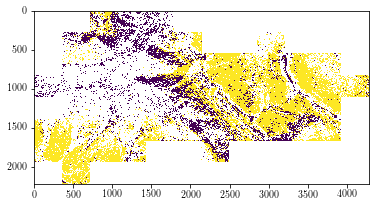

In [23]:
plt.imshow(aso_noveg)

Same with Preds

In [24]:
output = os.path.join(root, "veg/pred_and_veg")

In [25]:
command = gdal_build_vrt.format(resampling='bilinear',
                            output=output,
                            mask = glob(os.path.join(root, "preds/*merged.tif"))[0],  ## different from above
                            veg = os.path.join(root, "veg/veg_clipped_1m.tif"))
print(command)
Popen(command, shell=True).communicate()

gdalbuildvrt -overwrite -resolution lowest -separate -r bilinear -vrtnodata '-9999 -9999' /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/veg/pred_and_veg.vrt /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/preds/20180524_172637_0f2d_3B_AnalyticMS_SR_clip_merged.tif /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/veg/veg_clipped_1m.tif


(None, None)

In [26]:
veg_pred_masked = rio.open(output+'.vrt')

In [27]:
pred = veg_pred_masked.read(1, masked=True)
veg = veg_pred_masked.read(2, masked=True)

In [28]:
# create nodata mask which only preserves pixels which CONTAIN VEGETATION 
pred_veg_on_nodata_mask = ((veg.data == 0) | (pred.mask)).astype(bool)
pred_veg = pred.copy()
pred_veg.mask = pred_veg_on_nodata_mask
# or DON"T 
pred_veg_off_nodata_mask = ((veg.data == 1) | (pred.mask)).astype(bool)
pred_noveg = pred.copy()
pred_noveg.mask = pred_veg_off_nodata_mask


## Compute percentage covered by vegetation

In [29]:
data_pixels_count = np.sum(~pred.mask)

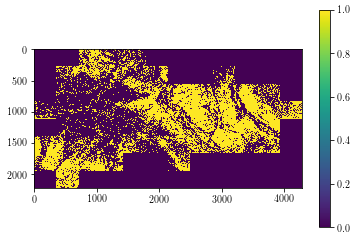

In [30]:
plt.imshow((~pred_veg_off_nodata_mask).astype('int') )
plt.colorbar()

In [31]:
veg_on_pixel_count = np.sum(~pred_veg_off_nodata_mask).astype('int')

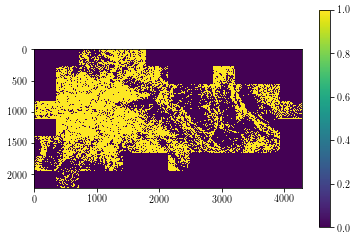

In [32]:
plt.imshow((~pred_veg_on_nodata_mask).astype('int') )
plt.colorbar()

In [33]:
veg_off_pixel_count = np.sum(~pred_veg_on_nodata_mask).astype('int')

In [34]:
percent_veg_on = veg_on_pixel_count / data_pixels_count * 100
print(f"Percent veg on: {percent_veg_on:.2f}%")

Percent veg on: 46.20%


In [35]:
percent_veg_off = veg_off_pixel_count / data_pixels_count * 100
print(f"Percent veg off: {percent_veg_off:.2f}%")

Percent veg off: 54.00%


## Compute Metrics on Veg and No Veg

In [36]:
true_veg, pred_veg = aso_veg[~aso_veg.mask].data, pred_veg[~pred_veg.mask].data

In [37]:
true_veg.shape, pred_veg.shape

((3106494,), (3106494,))

In [38]:
performance_veg = metrics.precision_recall_fscore_support(true_veg, pred_veg, average = 'binary')
accuracy_veg = metrics.balanced_accuracy_score(true_veg, pred_veg)

In [39]:
combined_veg = list(performance_veg[:3]) + [accuracy_veg]

In [40]:
combined_veg = pd.DataFrame.from_records([combined_veg], columns = ['Precision', "Recall", "F-Score", "Balanced Accuracy"]).assign(type='Vegetation Only')

In [41]:
true_noveg, pred_noveg = aso_noveg[~aso_noveg.mask].data, pred_noveg[~pred_noveg.mask].data

In [42]:
performance_noveg = metrics.precision_recall_fscore_support(true_noveg, pred_noveg, average = 'binary')
accuracy_noveg = metrics.balanced_accuracy_score(true_noveg, pred_noveg)

In [43]:
combined_noveg = list(performance_noveg[:3]) + [accuracy_noveg]

In [44]:
combined_noveg = pd.DataFrame.from_records([combined_noveg], columns = ['Precision', "Recall", "F-Score", "Balanced Accuracy"]).assign(type='No Vegetation')

In [45]:
original_melted = pd.melt(pd.concat([combined_noveg, combined_veg]), id_vars='type', value_vars=['Precision', "Recall", "F-Score", "Balanced Accuracy"]).assign(comparator='CubeSat ML')
original_melted.to_csv(os.path.join(root, "veg/veg_metrics.csv"), index=False)
original_melted

,type,variable,value,comparator
0,No Vegetation,Precision,0.924332,CubeSat ML
1,Vegetation Only,Precision,0.888728,CubeSat ML
2,No Vegetation,Recall,0.838694,CubeSat ML
3,Vegetation Only,Recall,0.454737,CubeSat ML
4,No Vegetation,F-Score,0.879433,CubeSat ML
5,Vegetation Only,F-Score,0.601635,CubeSat ML
6,No Vegetation,Balanced Accuracy,0.848016,CubeSat ML
7,Vegetation Only,Balanced Accuracy,0.706727,CubeSat ML


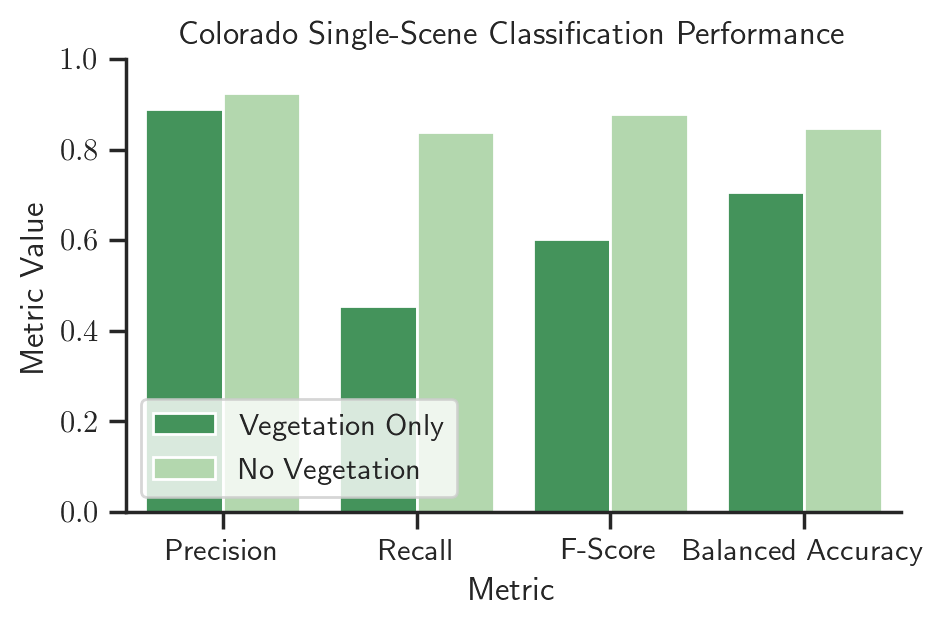

In [46]:
sns.set(style='ticks')
# plt.rc('text', usetex=True)

fig = plt.figure(figsize=(5,3), dpi=200)
sns.barplot(x='variable', y='value', hue='type', data=original_melted, hue_order=['Vegetation Only', "No Vegetation"], palette='Greens_r', dodge=True)
plt.legend(loc='lower left')
plt.ylim([0, 1])
plt.xlabel("Metric")
plt.ylabel("Metric Value")
plt.title("Colorado Single-Scene Classification Performance")
sns.despine()

In [47]:
combined_both = pd.concat([combined_noveg, combined_veg])

In [48]:
combined_both

,Precision,Recall,F-Score,Balanced Accuracy,type
0,0.924332,0.838694,0.879433,0.848016,No Vegetation
0,0.888728,0.454737,0.601635,0.706727,Vegetation Only


In [49]:
metric_diffs = []
for col in combined_both.columns[:4]:
    metric_diffs.append(functools.reduce(operator.isub, combined_both[col]))

In [50]:
metric_diffs

[0.035603716301714994,
 0.3839568351720773,
 0.2777983809640274,
 0.14128959571724053]

<BarContainer object of 4 artists>

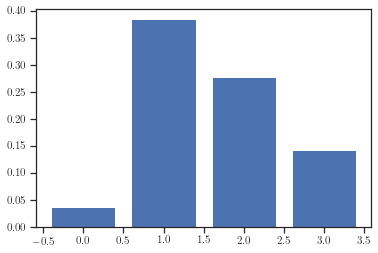

In [51]:
plt.bar(range(0, len(metric_diffs)), metric_diffs)

## Comparison to Sentinel-2 and LS8

In [52]:
comparator_dir = "/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/32776e534dede28c6635a4f4a15f723a"

In [53]:
gdal_combine = "gdalbuildvrt -overwrite -resolution lowest " \
               "-separate -r {resampling} -vrtnodata '-9999 -9999 -9999' " \
               "{output}.vrt {aso} {comparator} {veg}"
        

comparator_metrics = []
for comparator in ['NDSI-clipped-ls8_reprojected_clipped.tif', 'LC08_CU_010009_20180526_20190615_C01_V01_SNOW_05_convex_reprojected_clipped.tif']:
    output = os.path.join(root, f'veg/aso_{os.path.splitext(os.path.basename(comparator))[0]}_veg')
    command = gdal_combine.format(resampling='nearest',
                                  output=output,
                                  aso = glob(os.path.join(root, "mask/*merged.tif"))[0], 
                                  comparator = os.path.join(comparator_dir, comparator),
                                  veg = os.path.join(root, "veg/veg_clipped_1m.tif"))
    print(command)
    Popen(command, shell=True).communicate()
    
    merged_file = rio.open(output+'.vrt')
    _ASO = merged_file.read(1, masked=True)
    _comparator = merged_file.read(2, masked=True)
    _vegmask = merged_file.read(3, masked=True)
    print(_ASO.shape, _comparator.shape, _vegmask.shape)
    
    comp_nodata = rio.open(os.path.join(comparator_dir, comparator)).nodata
    # create nodata mask which only preserves pixels which CONTAIN VEGETATION 
    comp_veg_on_nodata_mask = ((_vegmask.data == 0) | (_ASO.mask) | (_comparator.data == comp_nodata)).astype(bool)
    comp_veg = _comparator.copy()
    comp_veg.mask = comp_veg_on_nodata_mask
    # or DON"T 
    comp_veg_off_nodata_mask = ((_vegmask.data == 1) | (_ASO.mask)| (_comparator.data == comp_nodata)).astype(bool)
    comp_noveg = _comparator.copy()
    comp_noveg.mask = comp_veg_off_nodata_mask
    
        # create nodata mask which only preserves pixels which CONTAIN VEGETATION
    aso_veg_on_nodata_mask = ((_vegmask.data == 0) | (_ASO.mask) | (_comparator.data == comp_nodata)).astype(bool)
    aso_veg = _ASO.copy()
    aso_veg.mask = aso_veg_on_nodata_mask
    # or DON'T
    aso_veg_off_nodata_mask = ((_vegmask.data == 1) | (_ASO.mask) | (_comparator.data == comp_nodata)).astype(bool)
    aso_noveg = _ASO.copy()
    aso_noveg.mask = aso_veg_off_nodata_mask
    
    print(aso_veg.shape, comp_veg.shape)

    true_veg, comp_veg = aso_veg[~aso_veg.mask].data, comp_veg[~comp_veg.mask].data
    performance_veg = metrics.precision_recall_fscore_support(true_veg, comp_veg, average = 'binary')
    accuracy_veg = metrics.balanced_accuracy_score(true_veg, comp_veg)
    
    true_noveg, comp_noveg = aso_noveg[~aso_noveg.mask].data, comp_noveg[~comp_noveg.mask].data
    performance_noveg = metrics.precision_recall_fscore_support(true_noveg, comp_noveg, average = 'binary')
    accuracy_noveg = metrics.balanced_accuracy_score(true_noveg, comp_noveg)
    
    
    combined_veg = pd.DataFrame.from_records([list(performance_veg[:3]) + [accuracy_veg]], columns = ['Precision', "Recall", "F-Score", "Balanced Accuracy"]).assign(type='Vegetation Only')
    combined_noveg = pd.DataFrame.from_records([list(performance_noveg[:3]) + [accuracy_noveg]], columns = ['Precision', "Recall", "F-Score", "Balanced Accuracy"]).assign(type='No Vegetation')
    melted = pd.melt(pd.concat([combined_noveg, combined_veg]), id_vars='type', value_vars=['Precision', "Recall", "F-Score", "Balanced Accuracy"]).assign(comparator=os.path.basename(output).split('_')[1])
    comparator_metrics.append(melted)

gdalbuildvrt -overwrite -resolution lowest -separate -r nearest -vrtnodata '-9999 -9999 -9999' /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/veg/aso_NDSI-clipped-ls8_reprojected_clipped_veg.vrt /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/mask/ASO_3M_SD_USCOGE_20180524_binary_merged.tif /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/32776e534dede28c6635a4f4a15f723a/NDSI-clipped-ls8_reprojected_clipped.tif /Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowc

In [54]:
all_comparators = pd.concat(comparator_metrics + [original_melted])

In [55]:
all_comparators

,type,variable,value,comparator
0,No Vegetation,Precision,0.973436,NDSI-clipped-ls8
1,Vegetation Only,Precision,0.933548,NDSI-clipped-ls8
2,No Vegetation,Recall,0.861171,NDSI-clipped-ls8
3,Vegetation Only,Recall,0.567484,NDSI-clipped-ls8
4,No Vegetation,F-Score,0.913869,NDSI-clipped-ls8
5,Vegetation Only,F-Score,0.705879,NDSI-clipped-ls8
6,No Vegetation,Balanced Accuracy,0.906247,NDSI-clipped-ls8
7,Vegetation Only,Balanced Accuracy,0.769181,NDSI-clipped-ls8
0,No Vegetation,Precision,0.918714,LC08
1,Vegetation Only,Precision,0.805568,LC08


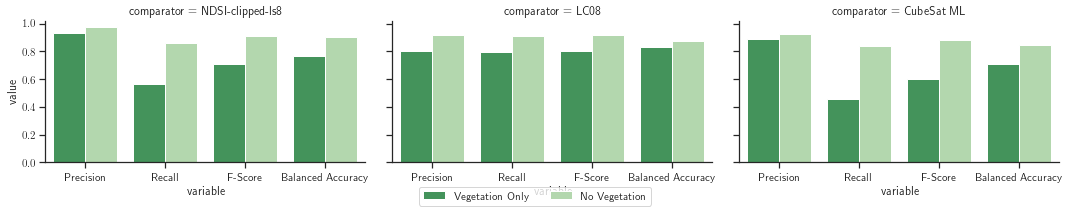

In [56]:
sns.set(style='ticks')
# plt.rc('text', usetex=True)


retval = sns.catplot(x='variable', y='value', hue='type', kind='bar', col='comparator', data=all_comparators, hue_order=['Vegetation Only', "No Vegetation"], palette='Greens_r', dodge=True, height=3, aspect=1.5)
sns.despine()
h,l = retval.axes[0][0].get_legend_handles_labels()
retval._legend.remove()
retval.fig.legend(h,l, ncol=2, loc='lower center') # you can specify any location parameter you want here
# plt.savefig("comparator_veg.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
# retval.fig.add_axes([0, 0, 0.2, 0.2])

### add og. general performance

In [57]:

# from `model-comparison.ipynb`
original_metrics = pd.read_csv(os.path.join(os.path.dirname(root), "comparator-metrics.csv")).assign(type="All Pixels").drop(['Unnamed: 0', 'index'], axis=1)


In [58]:
original_metrics

,SCA,image_id,variable,value,type
0,CubeSat ML,20180524_172142_103d_3B_AnalyticMS_SR_clip,Precision,0.958382,All Pixels
1,CubeSat ML,20180524_172143_103d_3B_AnalyticMS_SR_clip,Precision,0.833033,All Pixels
2,CubeSat ML,20180524_172144_103d_3B_AnalyticMS_SR_clip,Precision,0.792962,All Pixels
3,CubeSat ML,20180524_172145_103d_3B_AnalyticMS_SR_clip,Precision,0.856812,All Pixels
4,CubeSat ML,20180524_172326_0f51_3B_AnalyticMS_SR_clip,Precision,0.738694,All Pixels
...,...,...,...,...,...
175,Landsat 8 fSCA,20180524_172330_0f51_3B_AnalyticMS_SR_clip,Kappa,0.561309,All Pixels
176,Landsat 8 fSCA,20180524_172331_0f51_3B_AnalyticMS_SR_clip,Kappa,0.395526,All Pixels
177,Landsat 8 fSCA,20180524_172634_0f2d_3B_AnalyticMS_SR_clip,Kappa,0.452726,All Pixels
178,Landsat 8 fSCA,20180524_172635_0f2d_3B_AnalyticMS_SR_clip,Kappa,0.723014,All Pixels


In [59]:
original_metrics = original_metrics[original_metrics.image_id == '20180524_172637_0f2d_3B_AnalyticMS_SR_clip']

In [60]:
original_metrics.SCA.unique()

array(['CubeSat ML', 'Sentinel 2 NDSI', 'Landsat 8 fSCA'], dtype=object)

In [61]:
all_comparators_renamed = all_comparators.rename({'comparator': "SCA"}, axis=1).replace({
    'NDSI-clipped-ls8': "Sentinel 2 NDSI",
    "LC08": "Landsat 8 fSCA"
})
merged_all = pd.concat([all_comparators_renamed, original_metrics])


/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [62]:
merged_all = merged_all[~merged_all.variable.isin(['Kappa'])]
merged_all = merged_all.replace({'Balanced Accuracy', "Accuracy"})

In [84]:
colors = [
    "tab:green", # veg,
    "tab:brown",
    "tab:orange"
    #     'grey'#     cm.Greens(0.3), # veg,

]
cmap = sns.color_palette(colors)

In [86]:
resolutions = {
    "CubeSat ML" : "3 m",
    "Sentinel 2 NDSI": "10 m",
    "Landsat 8 fSCA": "30 m"
}

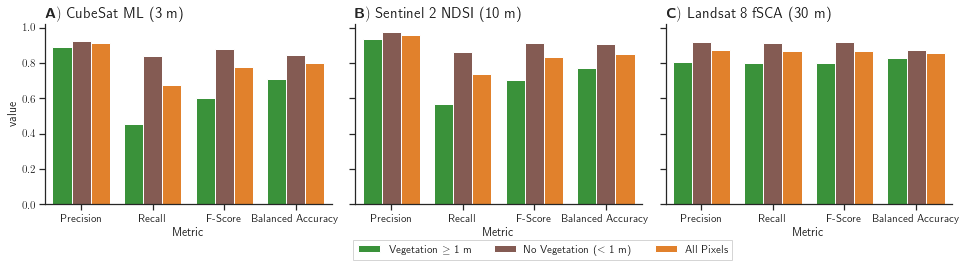

In [87]:
import matplotlib 
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plot = sns.catplot(x='variable', y='value', hue='type', kind='bar', col='SCA', data=merged_all,
                     col_order=["CubeSat ML", "Sentinel 2 NDSI", "Landsat 8 fSCA"], 
                     hue_order=['Vegetation Only', "No Vegetation", "All Pixels"],
                     palette=cmap, 
                     height=3, aspect=1.5, capsize=0.1, errwidth=1)

[ax.set_xlabel("Metric") for ax in list(plot.axes)[0]]
h,l = plot.axes[0][0].get_legend_handles_labels()
l = [
    r"Vegetation $\ge$ 1 m",
    r"No Vegetation ($<$ 1 m)",
    r"All Pixels"
]
plot._legend.remove()
plot.fig.legend(h,l, ncol=3, loc='center', bbox_to_anchor=(0.5,0.05), frameon=True, fancybox=False) # you can specify any location parameter you want here

# plot.set_titles(template='')
for i, ax in enumerate(plot.axes[0]):
    title = ax.get_title().split(" = ")[1]
    ax.set_title(r"$\textbf{" + ascii_uppercase[i] + r"})$ " + f"{title} (" + resolutions[title] + ")", loc='left', fontsize=15)
plot.set_titles(template='')



plot.fig.set_figheight(plot.fig.bbox_inches.bounds[3] + 0.7)
# plt.tight_layout()
plt.savefig("comparator_veg_all.png", dpi=300, bbox_inches='tight', )

